In [1]:
import pandas as pd
import geopandas as gpd
import fiona
import geopandas.geoseries  
import folium
import plotly.express as px
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx
from shapely import wkt

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


In [2]:
# Census tract to neighborhood function 
def nhdissolve(df,geometry):
    
    #Import neighborhood shapes
    url = "https://usc.data.socrata.com/api/geospatial/r8qd-yxsr?method=export&format=GeoJSON"
    nhoods=gpd.read_file(url)
   
    #This is to make the geography column recognizable, if you get an error you can try deleting this line from the code
    df[geometry] = df[geometry].apply(wkt.loads)
    #add a CRS
    gdf = gpd.GeoDataFrame(df, crs="EPSG:4326",geometry='geometry')
     #join race with nh shapes, rename neighborhood column, and set it as the index
    nhjoin=gdf.overlay(nhoods, how='intersection')
    nhjoin=nhjoin.rename(columns={'name':'Neighborhood'})
    nhjoin.set_index('Neighborhood',inplace=True)
    
    #drop shapes not in city of LA
    nhjoin.drop(nhjoin[nhjoin['type'] != 'segment-of-a-city'].index, inplace = True)

    #approximate average for data in neighborhoods 
    nhdata= nhjoin.dissolve(by='Neighborhood', aggfunc='sum')
    nhdata.head()
    return nhdata

In [3]:
# importing housing tenure data
tenure=pd.read_csv('data/tenuretracts.csv')

In [4]:
# plugging into function
tenure= nhdissolve(df=tenure,geometry='geometry')

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


In [5]:
tenure.head()

,geometry,Unnamed: 0,OBJECTID,CT20,FIPS,Occupied Housing Units,Occupied Housing Units: Owner Occupied,Occupied Housing Units: Renter Occupied
Neighborhood,,,,,,,,
Adams-Normandie,"POLYGON ((-118.30541 34.02571, -118.30890 34.0...",8267,11,2439227,66409439227,11109,2433,8676
Arleta,"POLYGON ((-118.43579 34.22987, -118.43582 34.2...",2064,14,1667245,84519667245,14695,11120,3575
Arlington Heights,"POLYGON ((-118.33381 34.03501, -118.33271 34.0...",9227,13,2820162,78483820162,15017,3954,11063
Atwater Village,"POLYGON ((-118.26888 34.11893, -118.27051 34.1...",7860,10,3125222,60373125222,15459,3141,12318
Baldwin Hills/Crenshaw,"POLYGON ((-118.35816 33.99909, -118.35819 33.9...",17850,20,6765265,120746765265,29496,12922,16574


In [6]:
# adding new rows with percent of renters and owners based on total number of households
tenure['Percent Renter Occupied'] = tenure['Occupied Housing Units: Renter Occupied'] / tenure['Occupied Housing Units'] * 100
tenure['Percent Owner Occupied'] = tenure['Occupied Housing Units: Owner Occupied'] / tenure['Occupied Housing Units'] * 100
tenure.head(10)

,geometry,Unnamed: 0,OBJECTID,CT20,FIPS,Occupied Housing Units,Occupied Housing Units: Owner Occupied,Occupied Housing Units: Renter Occupied,Percent Renter Occupied,Percent Owner Occupied
Neighborhood,,,,,,,,,,
Adams-Normandie,"POLYGON ((-118.30541 34.02571, -118.30890 34.0...",8267,11,2439227,66409439227,11109,2433,8676,78.098839,21.901161
Arleta,"POLYGON ((-118.43579 34.22987, -118.43582 34.2...",2064,14,1667245,84519667245,14695,11120,3575,24.328003,75.671997
Arlington Heights,"POLYGON ((-118.33381 34.03501, -118.33271 34.0...",9227,13,2820162,78483820162,15017,3954,11063,73.669841,26.330159
Atwater Village,"POLYGON ((-118.26888 34.11893, -118.27051 34.1...",7860,10,3125222,60373125222,15459,3141,12318,79.681739,20.318261
Baldwin Hills/Crenshaw,"POLYGON ((-118.35816 33.99909, -118.35819 33.9...",17850,20,6765265,120746765265,29496,12922,16574,56.190670,43.809330
Bel-Air,"POLYGON ((-118.45899 34.07444, -118.45914 34.0...",8139,10,2389024,60372389024,10980,9019,1961,17.859745,82.140255
Beverly Crest,"POLYGON ((-118.43181 34.08221, -118.43421 34.0...",9982,13,3738412,78484738412,16800,14001,2799,16.660714,83.339286
Beverly Grove,"POLYGON ((-118.37898 34.06971, -118.37944 34.0...",11293,14,4890115,84522890115,25465,6717,18748,73.622619,26.377381
Beverlywood,"POLYGON ((-118.39851 34.03721, -118.39921 34.0...",7267,8,2050705,48298050705,11733,5050,6683,56.959005,43.040995


In [7]:
tenure_web_mercator = tenure.to_crs(epsg=3857)

<AxesSubplot: >

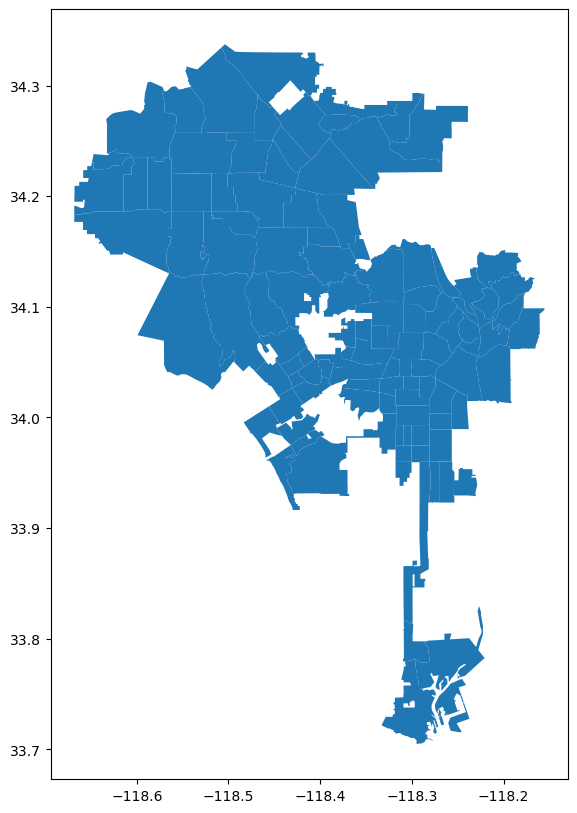

In [8]:
tenure.plot(figsize =(12,10))

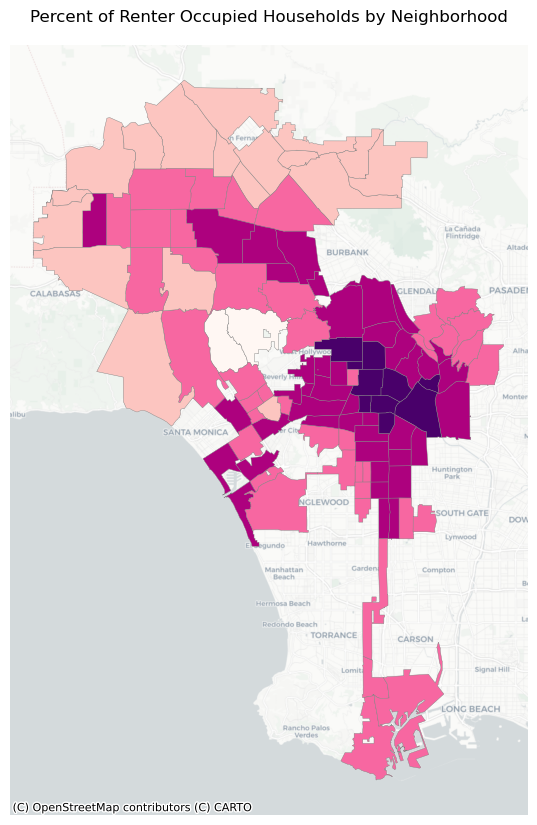

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
tenure_web_mercator.plot(
                 column='Percent Renter Occupied',
                 cmap='RdPu',
                 edgecolor='grey',
                 linewidth=0.3,
                 legend=False, 
                 scheme="User_Defined",
                 classification_kwds=dict(bins=[20,40,60,80,100]),
                 ax=ax)

ax.axis('off')

ax.set_title('Percent of Renter Occupied Households by Neighborhood')

ctx.add_basemap(ax, crs=3857, source=ctx.providers.CartoDB.Positron)

In [10]:
tenure = tenure.sort_values(by='Percent Renter Occupied',ascending=False)
tenure.head(10)

,geometry,Unnamed: 0,OBJECTID,CT20,FIPS,Occupied Housing Units,Occupied Housing Units: Owner Occupied,Occupied Housing Units: Renter Occupied,Percent Renter Occupied,Percent Owner Occupied
Neighborhood,,,,,,,,,,
Westlake,"POLYGON ((-118.28262 34.05283, -118.28421 34.0...",26456,43,8937086,259599937086,54227,3063,51164,94.351522,5.648478
Chinatown,"POLYGON ((-118.22701 34.06231, -118.22711 34.0...",5262,8,2408646,48298408646,8655,653,8002,92.455228,7.544772
Downtown,"POLYGON ((-118.27405 34.03712, -118.27402 34.0...",25097,39,8964923,235451964923,50554,4215,46339,91.662381,8.337619
East Hollywood,"POLYGON ((-118.30937 34.09077, -118.30940 34.0...",12687,26,5002364,156967002364,33274,2986,30288,91.026026,8.973974
University Park,"POLYGON ((-118.27974 34.01847, -118.28282 34.0...",9129,12,2678395,72446678395,9252,898,8354,90.293990,9.706010
Koreatown,"POLYGON ((-118.31591 34.05261, -118.31638 34.0...",30780,48,10064412,289786064412,64285,6310,57975,90.184335,9.815665
Pico-Union,"POLYGON ((-118.30029 34.03731, -118.30041 34.0...",17059,24,5220741,144893220741,24574,2755,21819,88.788964,11.211036
Hollywood,"POLYGON ((-118.34406 34.08331, -118.34411 34.0...",16185,33,6805425,199227805425,50900,6584,44316,87.064833,12.935167
Harvard Heights,"POLYGON ((-118.30041 34.03731, -118.30901 34.0...",7184,10,2180554,60372180554,10577,1838,8739,82.622672,17.377328
